In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [3]:
with ZipFile("/content/Potato___zip.zip",'r') as zip_ref:
  zip_ref.extractall()

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:

class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

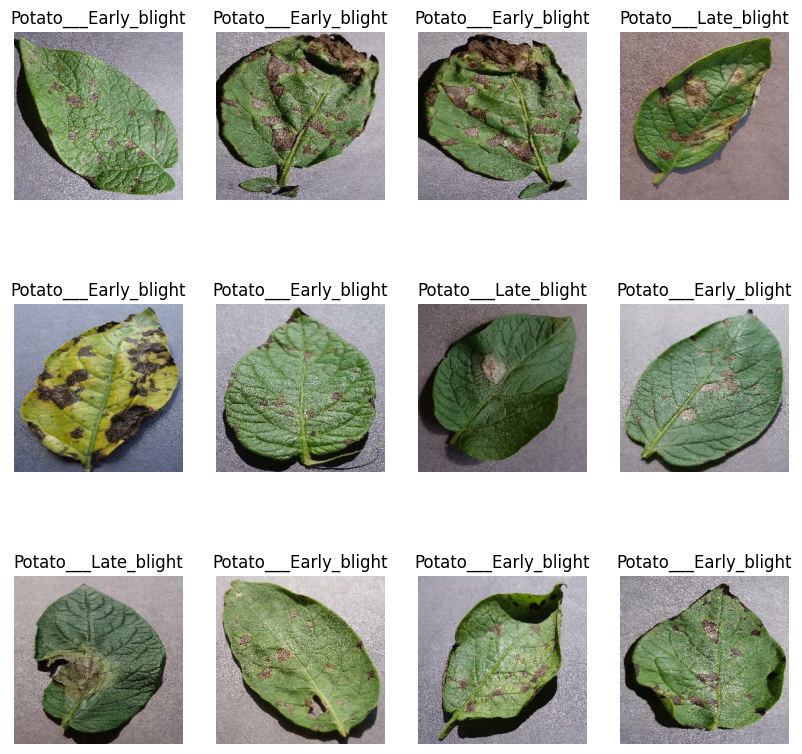

In [9]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)

68

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:

train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:

len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:

len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [22]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [23]:
from tensorflow.keras.layers import Resizing, Rescaling
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE), # Resizing layer is now directly under tf.keras.layers
    Rescaling(1./255), # Rescaling layer is also now directly under tf.keras.layers
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [24]:
from tensorflow.keras import layers
import tensorflow as tf #Make sure to import tensorflow

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),  # Remove 'preprocessing'
  layers.RandomRotation(0.2),  # Remove 'preprocessing'
])

#### Applying Data Augmentation to Train Dataset

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.**

In [26]:
from tensorflow.keras import layers, models, Input

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Remove BATCH_SIZE
n_classes = 3

# Define the input layer
input_tensor = Input(shape=input_shape)

# Apply resize_and_rescale to the input tensor
x = Resizing(IMAGE_SIZE, IMAGE_SIZE)(input_tensor)  # Apply Resizing to input tensor
x = Rescaling(1./255)(x)  # Apply Rescaling to the output of Resizing

# Build the rest of the model
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(n_classes, activation='softmax')(x)

# Create the model
model = models.Model(inputs=input_tensor, outputs=x)

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 433ms/step - accuracy: 0.4590 - loss: 0.9285 - val_accuracy: 0.6354 - val_loss: 0.7604
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 363ms/step - accuracy: 0.7131 - loss: 0.6441 - val_accuracy: 0.8073 - val_loss: 0.3923
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.8344 - loss: 0.4009 - val_accuracy: 0.8698 - val_loss: 0.2803
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.8659 - loss: 0.3347 - val_accuracy: 0.8438 - val_loss: 0.3435
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.8552 - loss: 0.3106 - val_accuracy: 0.8698 - val_loss: 0.2450
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.8943 - loss: 0.2645 - val_accuracy: 0.9010 - val_loss: 0.2245
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.9075 - loss: 0.2130 - val_accuracy: 0.9010 - val_loss: 0.1972
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.9204 - loss: 0.1866 - val_accu

**You can see above that we get 99% accuracy for our test dataset**

In [30]:

scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9540 - loss: 0.1128


In [31]:
scores

[0.12831328809261322, 0.9609375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [32]:

history

In [33]:

history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:

history.history['loss'][:5] # show loss for first 5 epochs


[0.8825657963752747,
 0.5860276222229004,
 0.3803209364414215,
 0.3574664294719696,
 0.30772489309310913]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

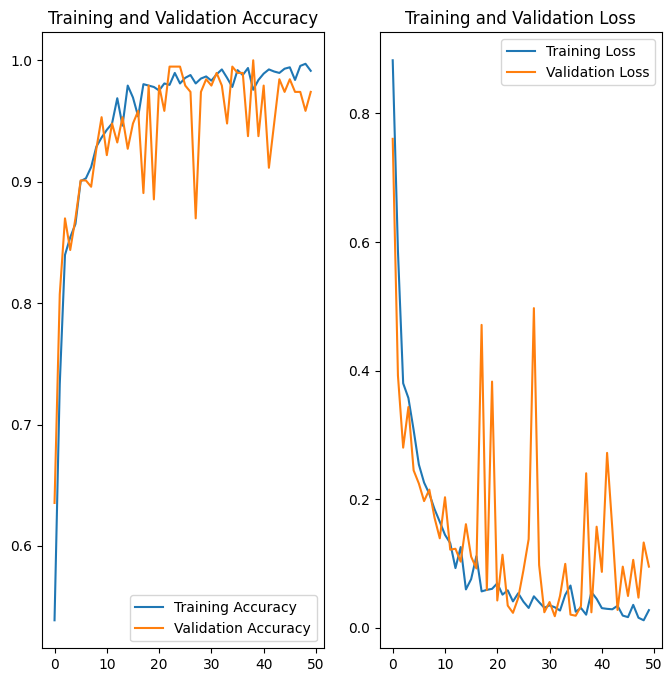

In [39]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
predicted label: Potato___Late_blight


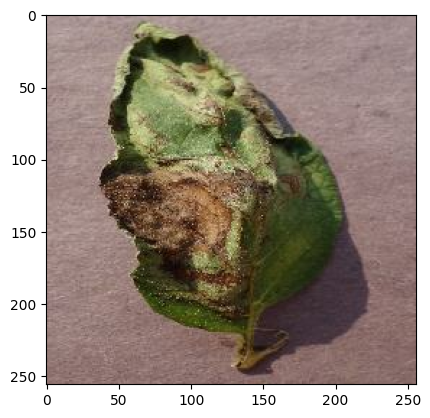

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [41]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


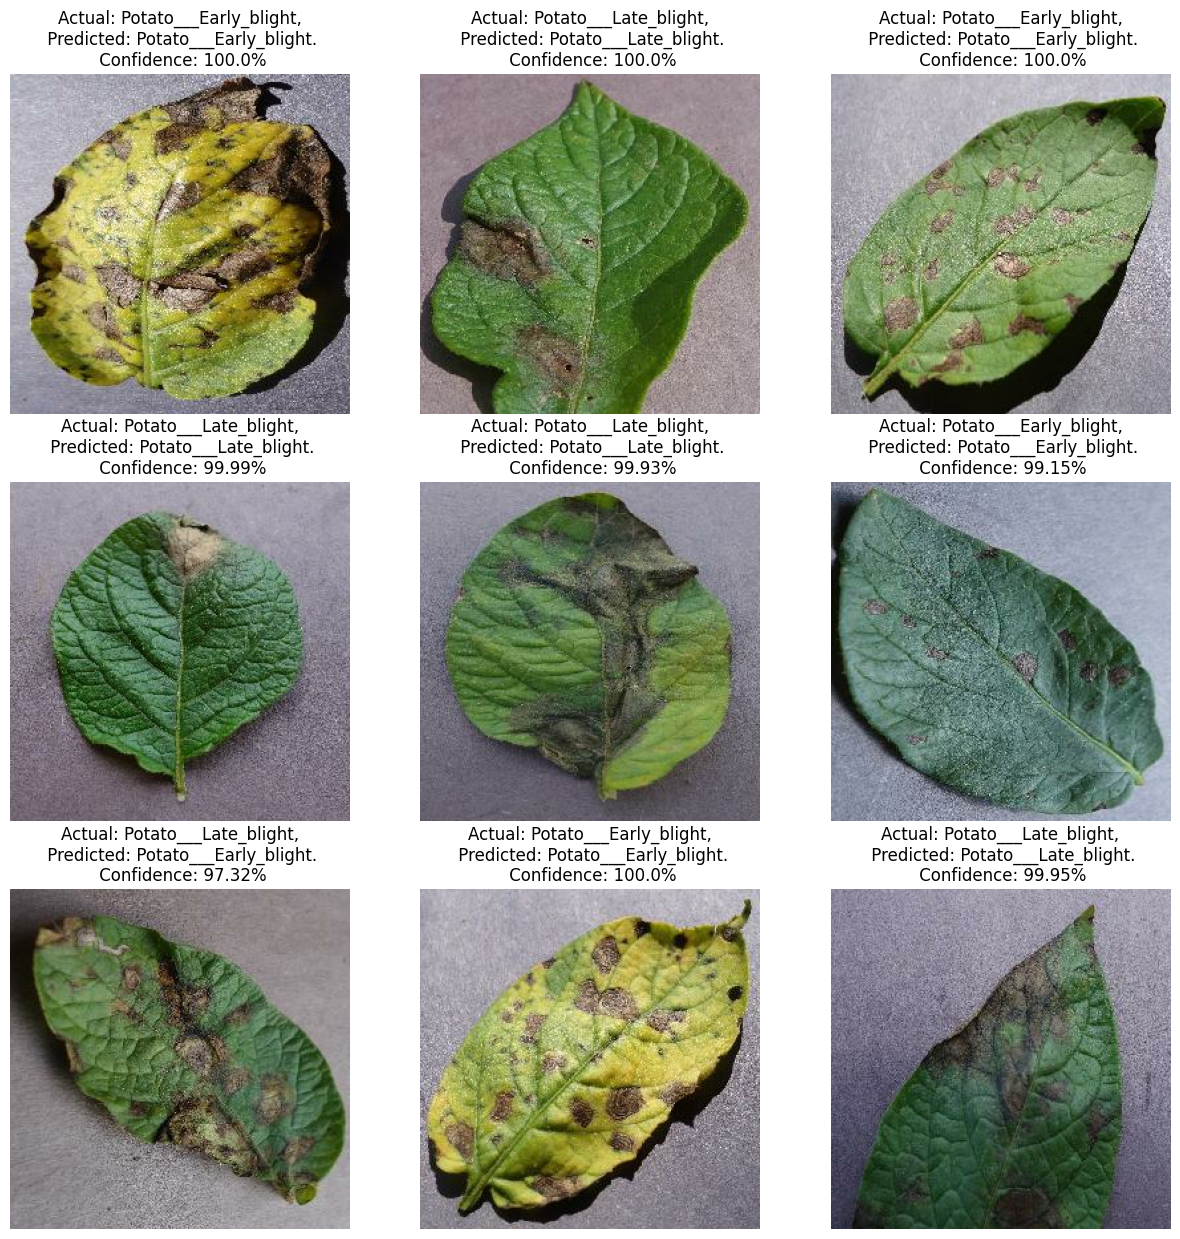

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [43]:
from PIL import Image
import numpy as np

# Function to Load and Preprocess the Image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image to match the model's input shape
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension (for model compatibility)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array  # No need to scale to [0, 1] as the model does this internally

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    # Preprocess the image
    preprocessed_img = load_and_preprocess_image(image_path)
    # Make predictions using the model
    predictions = model.predict(preprocessed_img)
    # Get the index of the highest probability class
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Map the index to the corresponding class name
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMAGE_SIZE = 256  # Match the input size of your model
BATCH_SIZE = 32   # Adjust as needed based on available memory and training efficiency

# Create an ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    validation_split=0.2  # Reserve 20% of data for validation
)

# Create the train_generator using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    'PlantVillage',            # Directory containing subdirectories for each class
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to match model input
    batch_size=BATCH_SIZE,     # Number of images per batch
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'          # Specify the training subset
)

# Create the class_indices dictionary to map indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}


Found 1722 images belonging to 3 classes.


In [45]:
class_indices

{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}

In [46]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [55]:
# Example Usage
image_path = '/content/potato_early_blight.JPG'
#image_path = '//content/potato_healthy.JPG'
#image_path = '//content/potato_late_blight.JPG'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class Name: Potato___Early_blight


In [54]:
# Save the model in the recommended native Keras format
model.save('plant_disease_prediction_model.keras')
